In [1]:
!pip install -q --upgrade selectivesearch torch_snippets

from torch_snippets import *
import selectivesearch
from google.colab import files

files.upload() # upload kaggle.json file
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d sixhky/open-images-bus-trucks/
!unzip -qq open-images-bus-trucks.zip

from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Saving kaggle.json to kaggle.json
kaggle.json
open-images-bus-trucks.zip: Skipping, found more recently modified local copy (use --force to force download)
replace df.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [2]:
IMAGE_ROOT = '/content/images/images'
DF_RAW = pd.read_csv('/content/df.csv')

DF_RAW.head(3)

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,0,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,0,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,0,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739


In [3]:
from custom_dataset import OpenImages

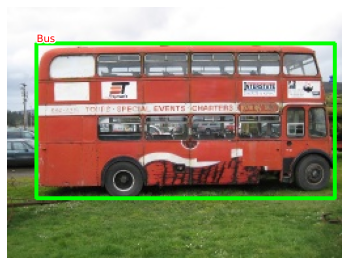

In [4]:
ds = OpenImages(df=DF_RAW)
im, bbs, clss, _ = ds[100]
show(im, bbs=bbs, texts=clss, sz=6)

In [5]:
from utils import extract_candidates, get_iou

In [6]:
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [],[],[],[],[],[]

N = 200
for ix, (im, bbs, labels, fpath) in enumerate(ds):
    if(ix==N):
        break

    H, W, _ = im.shape
    candidates = extract_candidates(img=im, min_area=0.1, max_area=0.75)
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])

    ious, rois, clss, deltas = [], [], [], []

    ious = np.array([[get_iou(_bb_, candidate) for candidate in candidates] for _bb_ in bbs]).T

    #################################################
    for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate
    
        candidate_ious = ious[jx]
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X,_Y = bbs[best_iou_at]
        if best_iou > 0.3: 
            clss.append(labels[best_iou_at])
        else :
            clss.append('background')   
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))
    
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)

In [7]:
FPATHS = [f'{IMAGE_ROOT}/{stem(f)}.jpg' for f in FPATHS] 
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

In [8]:
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']

In [9]:
normalize= transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

In [10]:
def preprocess_image(img, normalize=normalize):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()

In [11]:
def decode(_y):
    _, preds = _y.max(-1)
    return preds

In [12]:
class FRCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas

    def __len__(self): 
        return len(self.fpaths)
    
    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1]
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        assert len(rois) == len(labels) == len(deltas), f'{len(rois)}, {len(labels)}, {len(deltas)}'
        return image, rois, labels, deltas, gtbbs, fpath
    
    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas = [],[],[],[],[]
        for ix in range(len(batch)):
            image, image_rois, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            image = cv2.resize(image, (224,224))
            input.append(preprocess_image(image/255.)[None])
            rois.extend(image_rois)
            rixs.extend([ix]*len(image_rois))
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas) 
        input = torch.cat(input).to(device)
        rois = torch.Tensor(rois).float().to(device)
        rixs = torch.Tensor(rixs).float().to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, rois, rixs, labels, deltas         

In [13]:
n_train = 9*len(FPATHS)//10

train_ds = FRCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = FRCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])

In [14]:
from torch.utils.data import TensorDataset, DataLoader

train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

In [15]:
from torchvision.ops import RoIPool

In [16]:
class FRCNN(nn.Module):
    def __init__(self):
        super().__init__()
        rawnet = torchvision.models.vgg16_bn(pretrained=True)
        for param in rawnet.features.parameters():
            param.requires_grad = True
        self.seq = nn.Sequential(*list(rawnet.features.children())[:-1])
        self.roipool = RoIPool(7, spatial_scale=14/224)
        feature_dim = 512*7*7
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        self.bbox = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 4),
            nn.Tanh(),
        )
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss()

    def forward(self, input, rois, ridx):
        res = input
        res = self.seq(res)
        rois = torch.cat([ridx.unsqueeze(-1), rois*224], dim=-1)
        res = self.roipool(res, rois)
        feat = res.view(len(res), -1)
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat) #.view(-1,len(label2target),4)
        return cls_score, bbox
    
    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels != background_class)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

In [17]:
def train_batch(inputs, model, optimizer, criterion):
    input, rois, rixs, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input, rois, rixs)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [18]:
def validate_batch(inputs, model, criterion):
    input, rois, rixs, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input, rois, rixs)
        loss, loc_loss,regr_loss = criterion(_clss, _deltas, clss, deltas)
        _clss = decode(_clss)
        accs = clss == _clss
        return _clss, _deltas,loss.detach(), loc_loss,regr_loss, accs.cpu().numpy()

In [19]:
frcnn = FRCNN().to(device)
criterion = frcnn.calc_loss
optimizer = optim.SGD(frcnn.parameters(), lr=1e-3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


EPOCH: 20.000	val_loss: 1.036	val_loc_loss: 0.524	val_regr_loss: 0.051	val_acc: 0.744	(6890.64s - 0.00s remaining)

100%|██████████| 121/121 [00:00<00:00, 1545.58it/s]


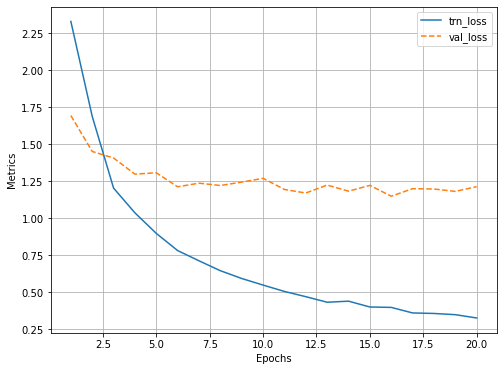

In [20]:
n_epochs = 20
log = Report(n_epochs)
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, frcnn, optimizer, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss, trn_regr_loss=regr_loss,
                   trn_acc=accs.mean(), end='\r')
        
    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, loc_loss, regr_loss, accs = validate_batch(inputs, frcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss, val_regr_loss=regr_loss,
                   val_acc=accs.mean(), end='\r')

# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from torchvision.ops import nms
from PIL import Image

In [22]:
def test_predictions(filename):
    img = cv2.resize(np.array(Image.open(filename)), (224,224))
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = preprocess_image(img/255.)[None]
    rois = [[x/224,y/224,X/224,Y/224] for x,y,X,Y in candidates]
    rixs = np.array([0]*len(rois))
    rois,rixs = [torch.Tensor(item).to(device) for item in [rois, rixs]]
    with torch.no_grad():
        frcnn.eval()
        probs, deltas = frcnn(input, rois, rixs)
        confs, clss = torch.max(probs, -1)
    candidates = np.array(candidates)
    confs,clss,probs,deltas=[tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]
    ixs = clss!=background_class
    confs, clss, probs, deltas,candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas,candidates]]
    bbs = candidates + deltas
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs,deltas,candidates,bbs = [tensor[ixs]
                                                for tensor in [confs,clss,probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs,clss, probs, deltas, candidates, bbs]]
    bbs = bbs.astype(np.uint16)

    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title(filename.split('/')[-1])
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    else:
        show(img,bbs=bbs.tolist(),texts=[target2label[c] for c in clss.tolist()],ax=ax[1])
        plt.show()

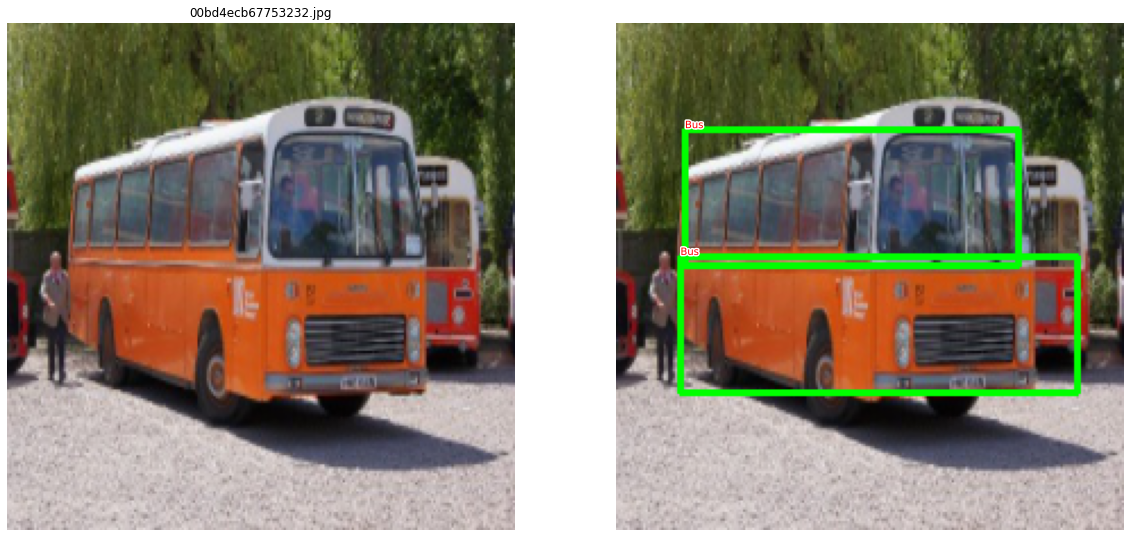

In [28]:
test_predictions(test_ds[3][-1])